In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import skgstat as skg
from geogenie.utils.scorers import haversine_distances_agg
from skgstat.plotting import backend

warnings.filterwarnings("ignore")

/Users/btm002/Documents/wtd/GeoGenIE/.gg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
actual_coords = pd.read_csv("../../original_locator/actual_coords.csv")

In [3]:
def jitter(df, sigma=0.01):
    df = df.copy()
    df["Latitude"] = df["Latitude"].apply(lambda x: np.random.normal(x, sigma))
    df["Longitude"] = df["Longitude"].apply(
        lambda x: np.random.normal(
            x,
            sigma,
        )
    )
    return df

In [4]:
actual_coords.describe()

,Longitude,Latitude
count,200.000000,200.000000
mean,-92.611551,35.316616
std,1.065759,0.946311
min,-94.491233,33.016142
25%,-93.401603,34.780660
50%,-92.853057,35.632837
75%,-91.880185,36.055982
max,-90.330369,36.483833


In [5]:
actual_coords_jitter = jitter(actual_coords, sigma=0.01)
actual_coords_jitter.describe()

,Longitude,Latitude
count,200.000000,200.000000
mean,-92.612637,35.316213
std,1.066190,0.946594
min,-94.510407,33.009072
25%,-93.402296,34.783291
50%,-92.843117,35.637601
75%,-91.876283,36.048014
max,-90.329119,36.494392


In [6]:
pred_coords = pd.read_csv("../../original_locator/test_pred_coords.csv")
pred_coords.describe()

,Longitude,Latitude
count,200.000000,200.000000
mean,-92.602579,35.289875
std,0.826488,0.839635
min,-94.097184,33.061195
25%,-93.288541,34.879911
50%,-92.790278,35.553346
75%,-92.036156,35.930145
max,-90.411277,36.390699


In [7]:
errors = haversine_distances_agg(
    actual_coords.to_numpy(), pred_coords.to_numpy(), np.array
)

errors = pd.Series(errors, name="Haversine Error")
errors.describe()

count    200.000000
mean      70.127790
std       72.992969
min        0.364962
25%       20.118150
50%       41.085741
75%       94.094176
max      378.096468
Name: Haversine Error, dtype: float64

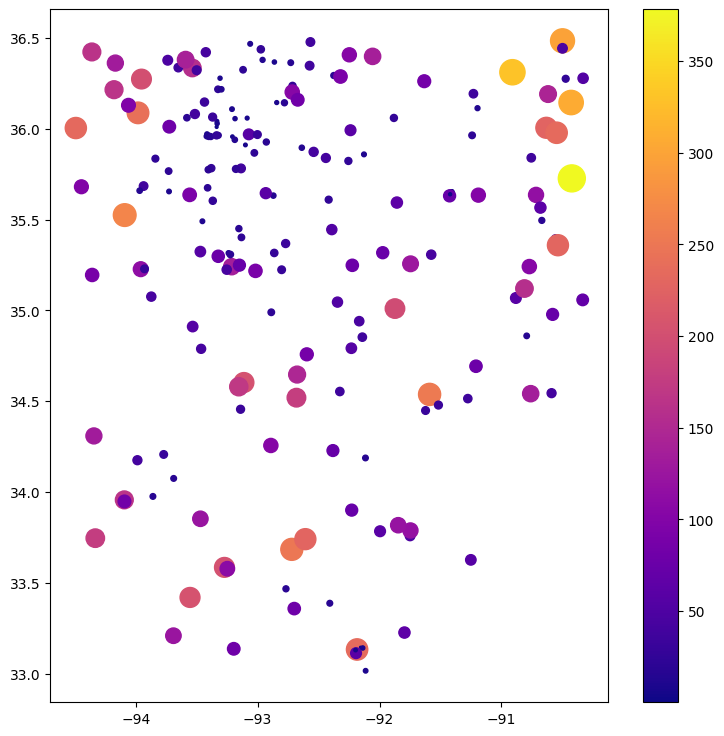

In [8]:
def make_scatterplot(df, errs):
    df = df.copy()
    lon = df.iloc[:, 0].to_numpy()
    lat = df.iloc[:, 1].to_numpy()
    errs = errors.to_numpy()

    fig, ax = plt.subplots(1, 1, figsize=(9, 9))
    art = ax.scatter(lon, lat, s=errs, c=errs, cmap="plasma")
    plt.colorbar(art)
    plt.show()


make_scatterplot(actual_coords, errors)

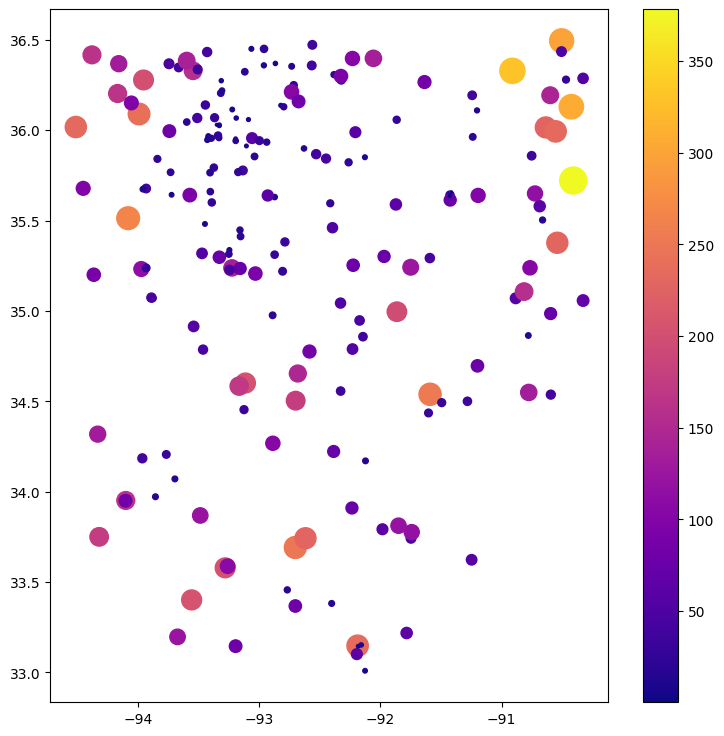

In [9]:
make_scatterplot(actual_coords_jitter, errors)

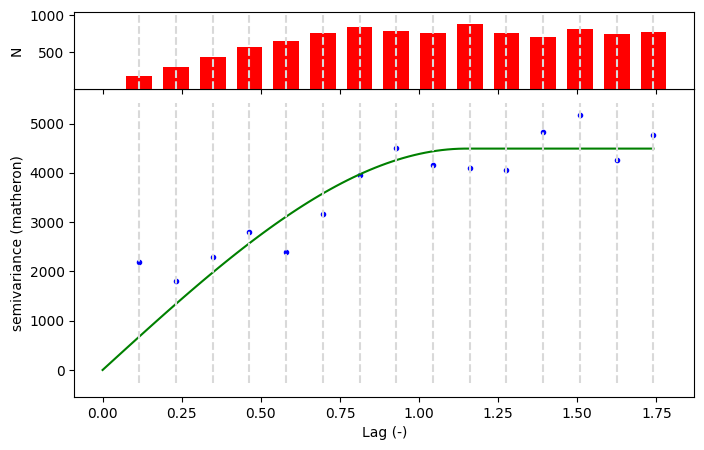

In [19]:
def make_variogram(coords, errs):
    V = skg.Variogram(coords, errs, maxlag="median", n_lags=15, normalize=False)
    V.plot(show=True)
    return V


V = make_variogram(actual_coords, errors)

In [20]:
V.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 2.000208827643963,
 'normalized_sill': 23205099.339937467,
 'normalized_nugget': 0,
 'effective_range': 1.1493266821013184,
 'sill': 4492.547566903453,
 'nugget': 0,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'even',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': False,
  'maxlag': 1.740330977078661,
  'n_lags': 15,
  'verbose': False},
 'kwargs': {}}

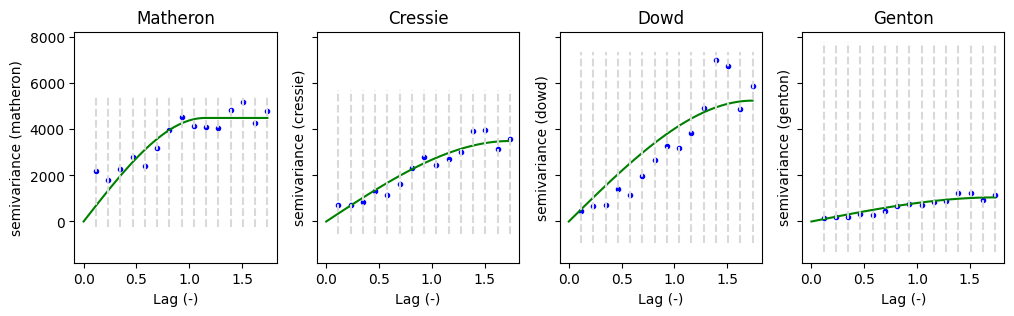

In [21]:
def plot_semi_estimators(V, estimator_names=("matheron", "cressie", "dowd", "genton")):
    vario = V
    fig, _a = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
    axes = _a.flatten()
    for ax, estimator_name in zip(axes, estimator_names):
        vario.estimator = estimator_name
        vario.plot(axes=ax, hist=True, show=True)
        ax.set_title(estimator_name.capitalize())


plot_semi_estimators(V)

In [39]:
V.estimator = "cressie"

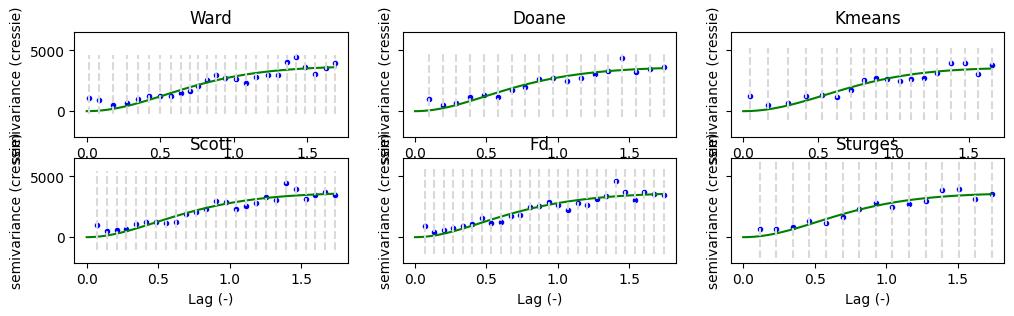

In [40]:
def plot_bin_funcs(
    vario, bin_funcs=("ward", "doane", "kmeans", "scott", "fd", "sturges")
):
    fig, _a = plt.subplots(2, 3, figsize=(12, 3), sharey=True)
    axes = _a.flatten()
    for ax, estimator_name in zip(axes, bin_funcs):
        vario.bin_func = estimator_name
        vario.plot(axes=ax, hist=False, show=False)
        ax.set_title(estimator_name.capitalize())


plot_bin_funcs(V)

In [41]:
V.bin_func = "ward"

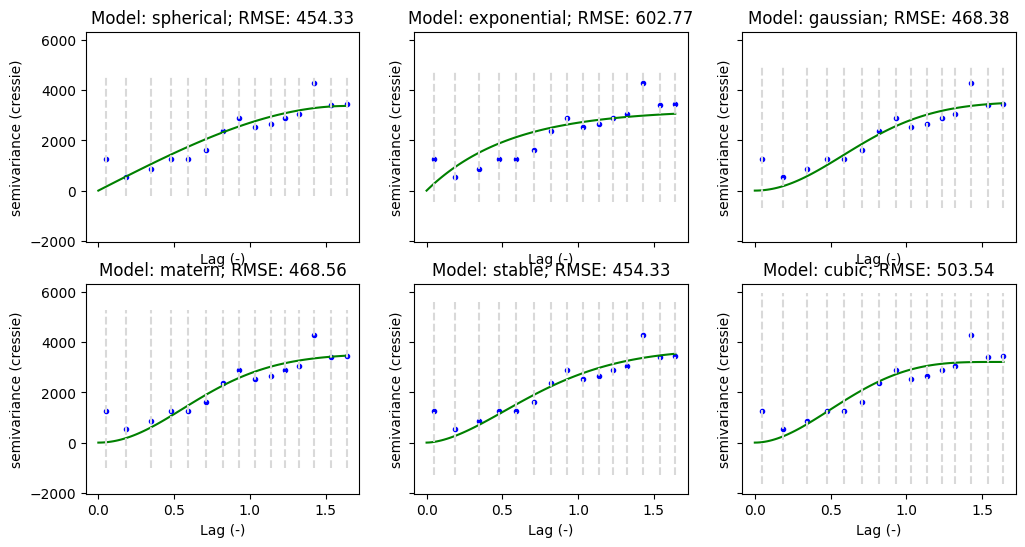

In [42]:
# we use the settings from before - scott rule
fig, _a = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(
    ("spherical", "exponential", "gaussian", "matern", "stable", "cubic")
):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title("Model: %s; RMSE: %.2f" % (model, V.rmse))

In [43]:
V.model = "stable"

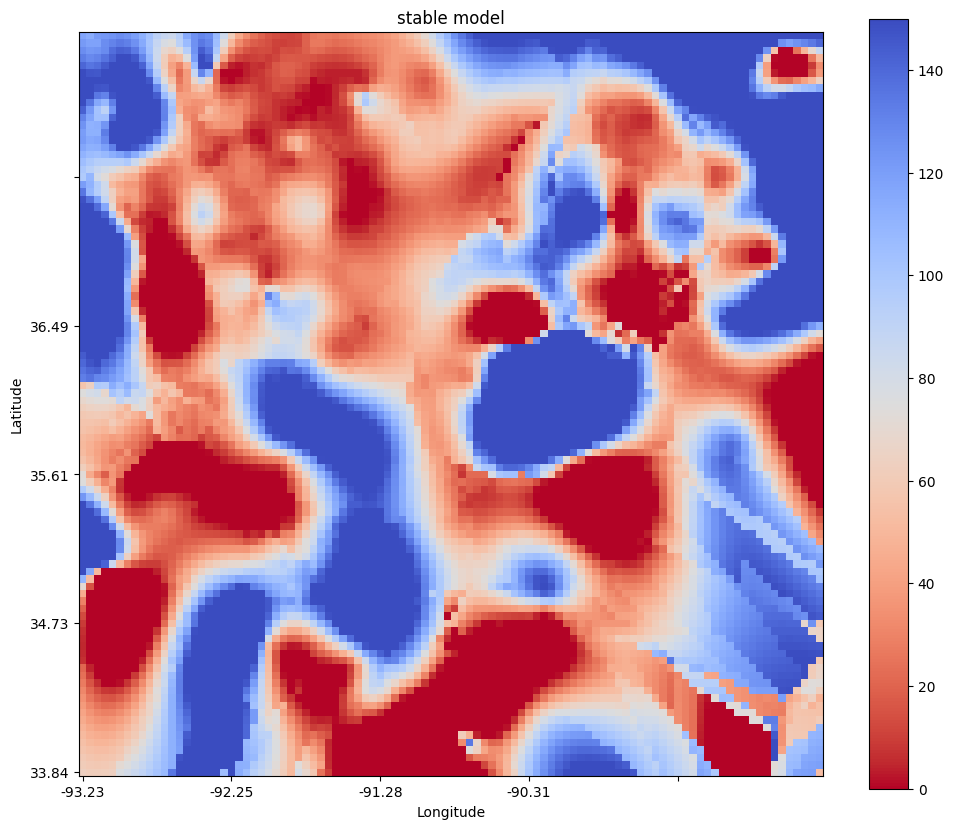

In [48]:
def interpolate(V, ax, coords, buffer=0.1):
    # Create a grid over the area of interest
    coords = coords.copy()
    coords = coords.to_numpy()

    xx, yy = np.meshgrid(
        np.linspace(
            coords[:, 0].min() - buffer,
            coords[:, 0].max() + buffer,
            100,
        ),
        np.linspace(
            coords[:, 1].min() - buffer,
            coords[:, 1].max() + buffer,
            100,
        ),
    )
    ok = skg.OrdinaryKriging(
        V,
        min_points=3,
        max_points=15,
        mode="exact",
    )
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    art = ax.matshow(
        field,
        origin="lower",
        cmap="coolwarm_r",
        vmin=0,
        vmax=150,
    )
    ax.set_title("%s model" % V.model.__name__)
    ax.set_xticklabels(
        np.round(
            np.linspace(
                coords[:, 0].min() - buffer,
                coords[:, 0].max() + buffer,
                num=5,
                endpoint=True,
            ),
            decimals=2,
        )
    )
    ax.set_yticklabels(
        np.round(
            np.linspace(
                coords[:, 1].min() - buffer,
                coords[:, 1].max() + buffer,
                num=5,
                endpoint=True,
            ),
            decimals=2,
        )
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(art, ax=ax)
    return field


fig, ax = plt.subplots(1, 1, figsize=(12, 10))
fields = interpolate(V, ax, pred_coords)